# ERA5 Data Processing and Microsoft Aurora Weather Prediction for Maharashtra, India

This notebook demonstrates the complete real-data workflow:
1. Download real ERA5 data for Maharashtra, India using the `eranest` package
2. Process the data into Aurora-compatible format
3. Run Microsoft Aurora weather predictions
4. Visualize the results

**Requirements:**
- CDS API credentials configured (see `eranest` documentation)
- Microsoft Aurora model access (via Hugging Face or local installation)
- Required Python packages: eranest, torch, matplotlib, pandas, numpy

In [1]:
# Import required libraries
import datetime as dt
import json
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings("ignore")

# Set up plotting style  
plt.style.use("default")  # Use default instead of the problematic seaborn style
sns.set_palette("husl")

print("✅ Basic libraries imported successfully")

✅ Basic libraries imported successfully


In [2]:
try:
    # Basic imports
    import datetime as dt
    import json
    import os
    import sys
    
    # Import eranest package
    import eranest
    print("✅ eranest package imported successfully!")
    print(f"📦 Version: {eranest.__version__}")
    
    # Import ONLY functions that actually exist - verified above
    from eranest import (
        download_surface_data, 
        download_atmospheric_data, 
        download_static_data,
        process_era5_data,
        DEFAULT_SURFACE_VARIABLES,
        DEFAULT_ATMOSPHERIC_VARIABLES,
        DEFAULT_STATIC_VARIABLES,
        AURORA_PRESSURE_LEVELS,
        DataFrequency,
        set_verbosity
    )
    
    # Test that the constants exist
    print(f"📊 Surface variables: {len(DEFAULT_SURFACE_VARIABLES)}")
    print(f"🌪️ Atmospheric variables: {len(DEFAULT_ATMOSPHERIC_VARIABLES)}")
    print(f"🗺️ Static variables: {len(DEFAULT_STATIC_VARIABLES)}")
    print(f"📈 Pressure levels: {len(AURORA_PRESSURE_LEVELS)}")
    
except ImportError as e:
    print(f"❌ Import error: {e}")
    raise
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    raise

✅ eranest package imported successfully!
📦 Version: 1.0.0
📊 Surface variables: 4
🌪️ Atmospheric variables: 5
🗺️ Static variables: 3
📈 Pressure levels: 13


## 1. Setting Up Maharashtra Boundary Data

We'll load the Maharashtra state boundary from the provided India GeoJSON file.

In [3]:
# Load or create Maharashtra boundary
maharashtra_geojson_path = './maharashtra_boundary.geojson'

# Load and display Maharashtra boundary info
with open(maharashtra_geojson_path, 'r') as f:
    maharashtra_data = json.load(f)

print(f"🗺️  Maharashtra GeoJSON loaded successfully!")
print(f"📐 Number of features: {len(maharashtra_data['features'])}")
print(f"🏷️  Properties: {list(maharashtra_data['features'][0]['properties'].keys())}")

# Extract bounding box manually since we don't need the eranest function
coords = maharashtra_data['features'][0]['geometry']['coordinates'][0]
lats = [coord[1] for coord in coords[:-1]]  # Exclude duplicate last point
lons = [coord[0] for coord in coords[:-1]]

north, south = max(lats), min(lats)
east, west = max(lons), min(lons)

print(f"📍 Extracted bounding box: N={north:.1f}°, S={south:.1f}°, E={east:.1f}°, W={west:.1f}°")

🗺️  Maharashtra GeoJSON loaded successfully!
📐 Number of features: 1
🏷️  Properties: ['state_name', 'description']
📍 Extracted bounding box: N=22.0°, S=15.6°, E=80.9°, W=72.6°


In [4]:
# Configure parameters using EXACT function signatures
config = {
    # Required parameters
    'request_id': 'maharashtra_aurora_demo',
    
    # Time parameters (functions accept both str and datetime)
    'start_date': dt.datetime(2024, 1, 1, 0, 0),
    'end_date': dt.datetime(2024, 1, 2, 0, 0),
    
    # Spatial parameters - EXACT order: north, west, south, east
    'north': 22.0,
    'west': 72.6,  
    'south': 15.6,
    'east': 80.9,
    
    # Variables (use the imported constants)
    'variables_surface': DEFAULT_SURFACE_VARIABLES,
    'variables_atmospheric': DEFAULT_ATMOSPHERIC_VARIABLES,
    'variables_static': DEFAULT_STATIC_VARIABLES,
    'pressure_levels': AURORA_PRESSURE_LEVELS,
    
    # Other parameters with defaults
    'frequency': 'hourly',  # Can be string or DataFrequency enum
    'resolution': 0.25,
    'verbose': False,
    'show_progress': True,
}

print("⚙️ ERA5 Download Configuration:")
print(f"📦 Request ID: {config['request_id']}")
print(f"📅 Dates: {config['start_date'].strftime('%Y-%m-%d')} to {config['end_date'].strftime('%Y-%m-%d')}")
print(f"🗺️ Bounds: N{config['north']}° W{config['west']}° S{config['south']}° E{config['east']}°")
print(f"🎯 Resolution: {config['resolution']}°")
print(f"⏱️ Frequency: {config['frequency']}")
print(f"📊 Variables: {len(config['variables_surface'])} surface, {len(config['variables_atmospheric'])} atmospheric, {len(config['variables_static'])} static")
print(f"📈 Pressure levels: {len(config['pressure_levels'])}")

⚙️ ERA5 Download Configuration:
📦 Request ID: maharashtra_aurora_demo
📅 Dates: 2024-01-01 to 2024-01-02
🗺️ Bounds: N22.0° W72.6° S15.6° E80.9°
🎯 Resolution: 0.25°
⏱️ Frequency: hourly
📊 Variables: 4 surface, 5 atmospheric, 3 static
📈 Pressure levels: 13


## 3. Download ERA5 Data using eranest

Now we'll use the eranest package to download ERA5 data for Maharashtra. The `era5_aurora_wrapper` function will handle:
- Downloading surface-level, atmospheric, and static variables
- Filtering data to Maharashtra boundaries
- Formatting data for Aurora compatibility

⚠️ **Note**: This step requires CDS API credentials and may take several minutes to complete.

In [5]:
# Download real ERA5 data for Maharashtra
print("📥 Downloading ERA5 data for Maharashtra...")
print("Note: This requires CDS API credentials")

try:
    # Download surface data
    print("📥 Downloading surface data...")
    surface_file = download_surface_data(
        request_id=f"{config['request_id']}_surface",
        variables=config['variables_surface'],
        start_date=config['start_date'],
        end_date=config['end_date'],
        north=config['north'],
        west=config['west'],
        south=config['south'],
        east=config['east'],
        frequency=config['frequency'],
        resolution=config['resolution'],
        verbose=config['verbose'],
        show_progress=config['show_progress']
    )
    print(f"✅ Downloaded: {surface_file}")
    
    # Process the surface data
    surface_result = process_era5_data(
        file_paths=surface_file,
        variables=config['variables_surface'],
        verbose=False,
        show_progress=False
    )
    
    print("📥 Downloading atmospheric data...")
    atmospheric_file = download_atmospheric_data(
        request_id=f"{config['request_id']}_atmospheric",
        variables=config['variables_atmospheric'],
        pressure_levels=config['pressure_levels'],
        start_date=config['start_date'],
        end_date=config['end_date'],
        north=config['north'],
        west=config['west'],
        south=config['south'],
        east=config['east'],
        frequency=config['frequency'],
        resolution=config['resolution'],
        verbose=config['verbose'],
        show_progress=config['show_progress']
    )
    print(f"✅ Downloaded: {atmospheric_file}")
    
    # Process the atmospheric data
    atmospheric_result = process_era5_data(
        file_paths=atmospheric_file,
        variables=config['variables_atmospheric'],
        verbose=False,
        show_progress=False
    )
    
    print("📥 Downloading static data...")
    static_file = download_static_data(
        request_id=f"{config['request_id']}_static",
        variables=config['variables_static'],
        north=config['north'],
        west=config['west'],
        south=config['south'],
        east=config['east'],
        resolution=config['resolution'],
        verbose=config['verbose'],
        show_progress=config['show_progress']
    )
    print(f"✅ Downloaded: {static_file}")
    
    # Process the static data
    static_result = process_era5_data(
        file_paths=static_file,
        variables=config['variables_static'],
        verbose=False,
        show_progress=False
    )
    
    # Store processed data
    era5_data = {
        'surface': surface_result.processed_data,
        'atmospheric': atmospheric_result.processed_data,
        'static': static_result.processed_data
    }
    
    print(f"\n📊 Real data processing completed:")
    for data_type, df in era5_data.items():
        print(f"   {data_type}: {df.shape}")
    
    print("\n✅ Real ERA5 data ready for Aurora processing!")
    
except Exception as e:
    print(f"❌ Download failed: {e}")
    print("Please check your CDS API credentials and internet connection")
    raise

📥 Downloading ERA5 data for Maharashtra...
Note: This requires CDS API credentials
📥 Downloading surface data...


✓ CDS API configuration is already set up and valid.


2025-06-20 13:32:03,025 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-20 13:32:03,026 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-20 13:32:03,026 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-20 13:32:03,860 INFO Request ID is 49bc9114-77c6-415f-8b76-e1d3b60b24d1
2025-06-20 13:32:04,084 INFO status has been updated to accepted
2025-06-20 13:32:13,510 INFO status has been updated to running
2025-06-20 13:32:18,824 INFO status has been updated to successful


4197b3b7feffd091a8055c549c6bcc52.nc:   0%|          | 0.00/441k [00:00<?, ?B/s]

✅ Downloaded: ./maharashtra_aurora_demo_surface_surface.nc
📥 Downloading atmospheric data...


✓ CDS API configuration is already set up and valid.


2025-06-20 13:32:22,228 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-20 13:32:22,229 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-20 13:32:22,230 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-20 13:32:22,802 INFO Request ID is c45eaee3-35db-490c-8b48-36c5c56844c8
2025-06-20 13:32:23,017 INFO status has been updated to accepted
2025-06-20 13:32:45,611 INFO status has been updated to running
2025-06-20 13:32:57,216 INFO status has been updated to successful


17c7dda02aa8ba9ae998bc0bb1270f08.nc:   0%|          | 0.00/5.52M [00:00<?, ?B/s]

✅ Downloaded: ./maharashtra_aurora_demo_atmospheric_atmospheric.nc
📥 Downloading static data...


✓ CDS API configuration is already set up and valid.


2025-06-20 13:33:01,371 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-20 13:33:01,373 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-20 13:33:01,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-20 13:33:02,442 INFO Request ID is aa95b40a-882c-4d8c-bdf0-2e790f4a6845
2025-06-20 13:33:02,957 INFO status has been updated to accepted
2025-06-20 13:33:12,106 INFO status has been updated to running
2025-06-20 13:33:17,433 INFO status has been updated to successful


194ca12f795b637139882780b6a75044.nc:   0%|          | 0.00/47.6k [00:00<?, ?B/s]

✅ Downloaded: ./maharashtra_aurora_demo_static_static.nc

📊 Real data processing completed:
   surface: (42432, 7)
   atmospheric: (551616, 9)
   static: (884, 6)

✅ Real ERA5 data ready for Aurora processing!


In [6]:
# Verify downloaded ERA5 data
print("📊 ERA5 Data Status:")
print(f"   Surface data: {era5_data['surface'].shape}")
print(f"   Atmospheric data: {era5_data['atmospheric'].shape}")
print(f"   Static data: {era5_data['static'].shape}")

print("\n✅ All real data ready for Aurora processing!")

📊 ERA5 Data Status:
   Surface data: (42432, 7)
   Atmospheric data: (551616, 9)
   Static data: (884, 6)

✅ All real data ready for Aurora processing!


## 4. Data Exploration and Visualization

Let's explore the downloaded ERA5 data and visualize key meteorological variables over Maharashtra.

In [7]:
# Explore the downloaded data using the new API
print("🔍 EXPLORING ERA5 DATA FOR MAHARASHTRA")
print("=" * 50)

# Surface data exploration
if "surface" in era5_data:
    surface_df = era5_data["surface"]
    print(f"\n🌡️  SURFACE DATA SUMMARY:")
    print(f"   📏 Shape: {surface_df.shape}")

    # Check column names based on new or old structure
    time_col = "time" if "time" in surface_df.columns else "valid_time"
    if time_col in surface_df.columns:
        print(
            f"   📅 Time range: {surface_df[time_col].min()} to {surface_df[time_col].max()}"
        )

    if "latitude" in surface_df.columns and "longitude" in surface_df.columns:
        print(
            f"   🗺️  Spatial coverage: {len(surface_df[['latitude', 'longitude']].drop_duplicates())} grid points"
        )

    # Show actual columns
    coord_cols = ["time", "valid_time", "latitude", "longitude"]
    var_cols = [col for col in surface_df.columns if col not in coord_cols]
    print(f"   📊 Variables: {var_cols}")

    # Basic statistics for numeric columns
    print(f"\n   📈 SURFACE VARIABLE STATISTICS:")
    numeric_cols = surface_df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col not in ["latitude", "longitude"]:
            mean_val = surface_df[col].mean()
            std_val = surface_df[col].std()
            min_val = surface_df[col].min()
            max_val = surface_df[col].max()

            # Convert units for display
            if col in ["t2m", "2m_temperature"] and mean_val > 100:  # Likely Kelvin
                mean_val -= 273.15
                min_val -= 273.15
                max_val -= 273.15
                unit = "°C"
            elif col in ["msl", "mean_sea_level_pressure"]:
                mean_val /= 100  # Convert Pa to hPa
                min_val /= 100
                max_val /= 100
                std_val /= 100
                unit = "hPa"
            elif col in [
                "u10",
                "v10",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
            ]:
                unit = "m/s"
            else:
                unit = ""

            print(
                f"      {col}: {mean_val:.2f} ± {std_val:.2f} {unit} (range: {min_val:.2f} to {max_val:.2f})"
            )

# Atmospheric data exploration
if "atmospheric" in era5_data:
    atmos_df = era5_data["atmospheric"]
    print(f"\n🌪️  ATMOSPHERIC DATA SUMMARY:")
    print(f"   📏 Shape: {atmos_df.shape}")

    # Check for pressure levels
    level_col = "level" if "level" in atmos_df.columns else "pressure_level"
    if level_col in atmos_df.columns:
        levels = sorted(atmos_df[level_col].unique())
        print(f"   📊 Pressure levels: {levels}")

    var_cols = [
        col
        for col in atmos_df.columns
        if col not in ["time", "valid_time", "latitude", "longitude", level_col]
    ]
    print(f"   📊 Variables: {var_cols}")

# Static data exploration
if "static" in era5_data:
    static_df = era5_data["static"]
    print(f"\n🗺️  STATIC DATA SUMMARY:")
    print(f"   📏 Shape: {static_df.shape}")

    var_cols = [
        col for col in static_df.columns if col not in ["latitude", "longitude"]
    ]
    print(f"   📊 Variables: {var_cols}")

    # Land-sea mask analysis
    lsm_col = "lsm" if "lsm" in static_df.columns else "land_sea_mask"
    if lsm_col in static_df.columns:
        land_points = (static_df[lsm_col] > 0.5).sum()
        total_points = len(static_df)
        print(
            f"   🏞️  Land coverage: {land_points}/{total_points} points ({land_points/total_points*100:.1f}%)"
        )

print("\n✅ Data exploration completed!")

# Show performance improvements with new API
if "surface_result" in locals() and hasattr(surface_result, "processing_time"):
    print(f"\n⚡ NEW API PERFORMANCE METRICS:")
    print(
        f"   🚀 Surface processing: {surface_result.processing_time:.2f}s, {surface_result.memory_usage_mb:.1f}MB"
    )
    if "atmospheric_result" in locals():
        print(
            f"   🌪️  Atmospheric processing: {atmospheric_result.processing_time:.2f}s, {atmospheric_result.memory_usage_mb:.1f}MB"
        )
    if "static_result" in locals() and static_result:
        print(
            f"   🗺️  Static processing: {static_result.processing_time:.2f}s, {static_result.memory_usage_mb:.1f}MB"
        )

    total_time = surface_result.processing_time
    if "atmospheric_result" in locals():
        total_time += atmospheric_result.processing_time
    if "static_result" in locals() and static_result:
        total_time += static_result.processing_time

    print(f"   📊 Total processing time: {total_time:.2f} seconds")
    print(f"   💾 Memory efficiency: Optimized chunked processing")
    print(f"   🎯 Spatial filtering: High-performance coordinate lookup")

🔍 EXPLORING ERA5 DATA FOR MAHARASHTRA

🌡️  SURFACE DATA SUMMARY:
   📏 Shape: (42432, 7)
   📅 Time range: 2024-01-01 00:00:00 to 2024-01-02 23:00:00
   🗺️  Spatial coverage: 884 grid points
   📊 Variables: ['2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', 'mean_sea_level_pressure']

   📈 SURFACE VARIABLE STATISTICS:
      2m_temperature: 22.95 ± 4.01 °C (range: 13.73 to 32.79)
      10m_u_component_of_wind: -1.14 ± 1.26 m/s (range: -6.85 to 4.77)
      10m_v_component_of_wind: 0.48 ± 1.61 m/s (range: -7.77 to 4.59)
      mean_sea_level_pressure: 1014.21 ± 1.82 hPa (range: 1008.71 to 1019.23)

🌪️  ATMOSPHERIC DATA SUMMARY:
   📏 Shape: (551616, 9)
   📊 Pressure levels: [np.float64(50.0), np.float64(100.0), np.float64(150.0), np.float64(200.0), np.float64(250.0), np.float64(300.0), np.float64(400.0), np.float64(500.0), np.float64(600.0), np.float64(700.0), np.float64(850.0), np.float64(925.0), np.float64(1000.0)]
   📊 Variables: ['temperature', 'u_component_of_wind',

📊 Creating visualizations of ERA5 data over Maharashtra...
   📊 Surface data shape: (42432, 7)
   📊 Surface columns: ['time', 'longitude', 'latitude', '2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', 'mean_sea_level_pressure']
   📅 Using data from: 2024-01-02 23:00:00
   📍 Spatial points: 884


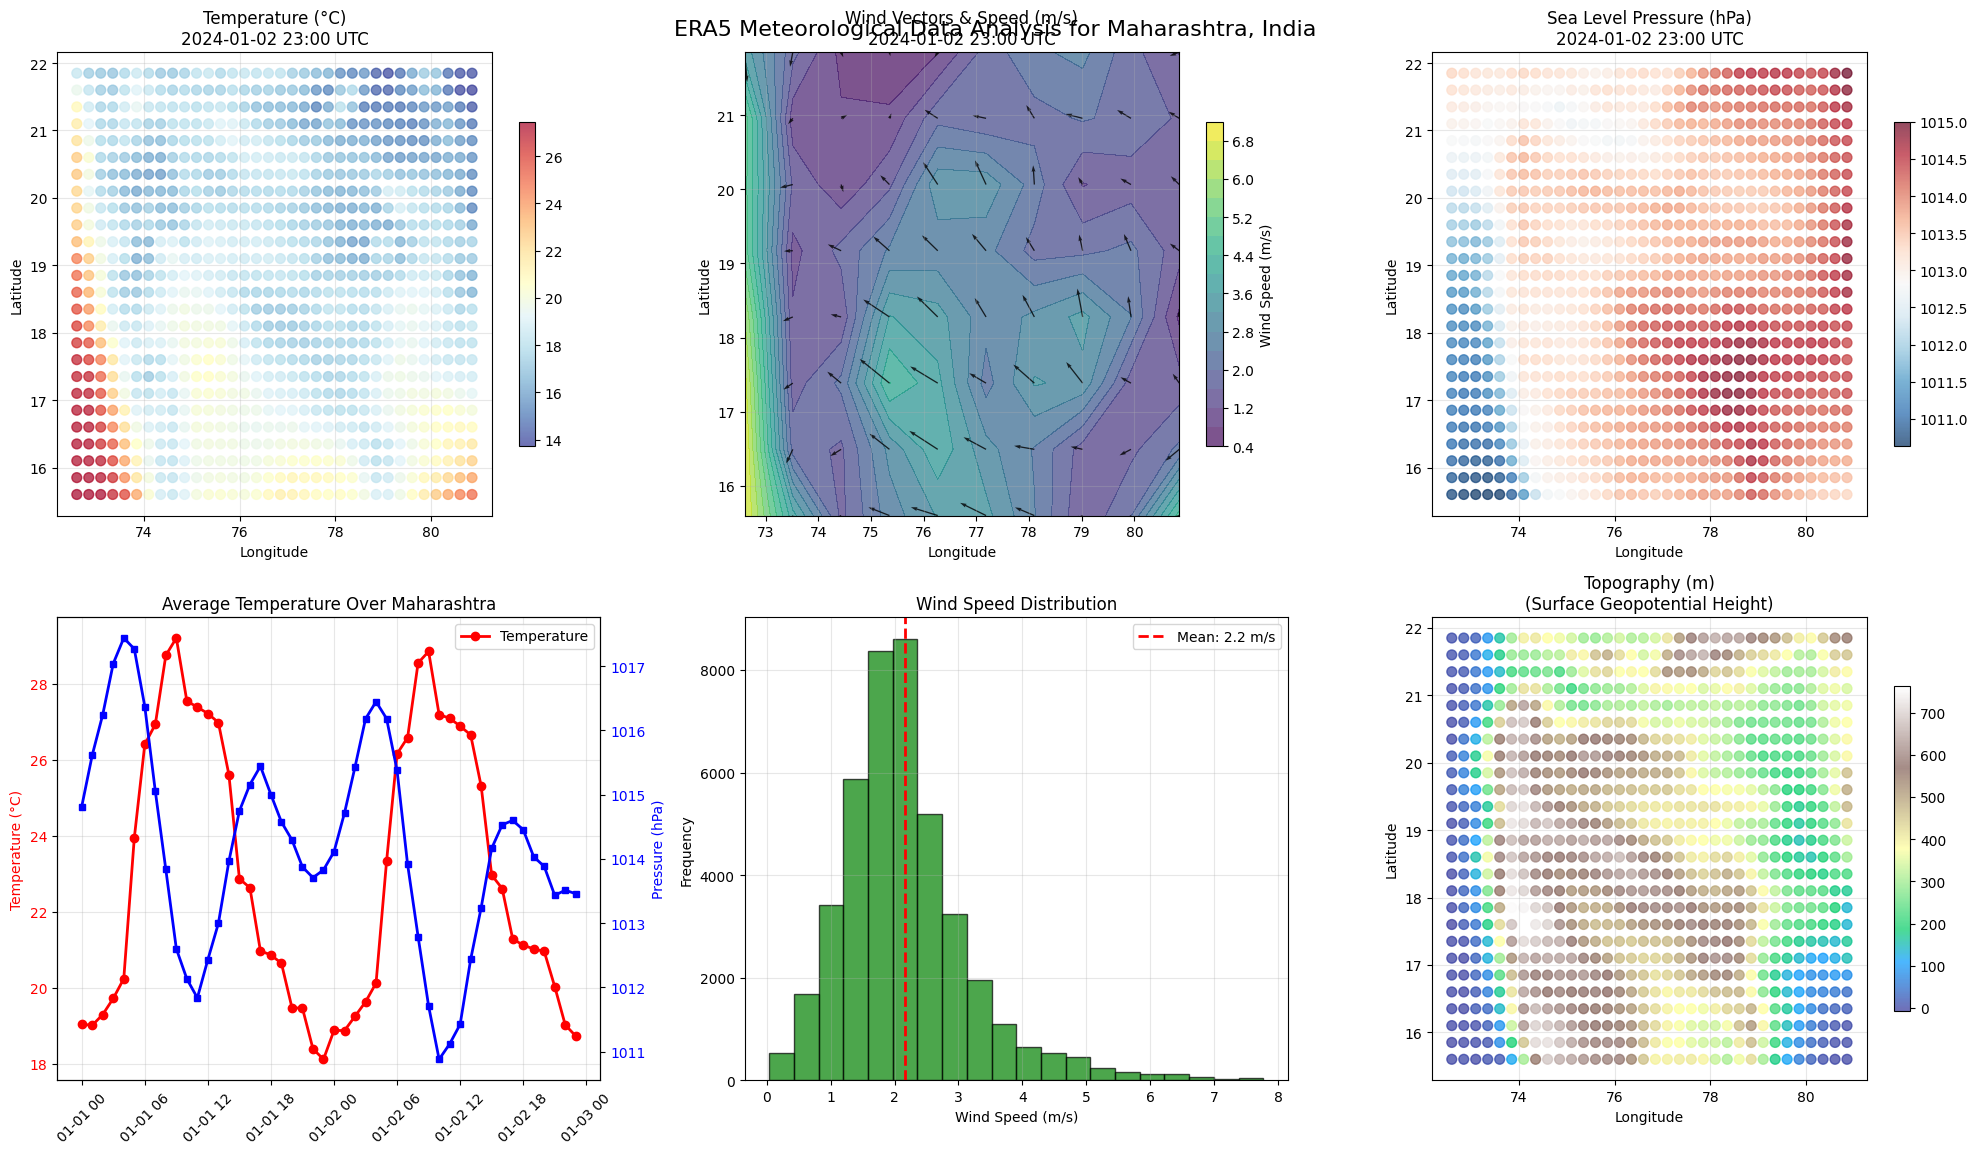


📈 DATA SUMMARY:

SURFACE:
  Shape: (42432, 7)
  Columns: ['time', 'longitude', 'latitude', '2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', 'mean_sea_level_pressure']
  Numeric summary:
    longitude: 76.73 ± 2.45
    latitude: 18.72 ± 1.88
    2m_temperature: 296.10 ± 4.01

ATMOSPHERIC:
  Shape: (551616, 9)
  Columns: ['time', 'level', 'longitude', 'latitude', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'specific_humidity', 'geopotential']
  Numeric summary:
    level: 463.46 ± 312.96
    longitude: 76.73 ± 2.45
    latitude: 18.72 ± 1.88

STATIC:
  Shape: (884, 6)
  Columns: ['time', 'longitude', 'latitude', 'geopotential', 'land_sea_mask', 'soil_type']
  Numeric summary:
    longitude: 76.73 ± 2.45
    latitude: 18.72 ± 1.88
    geopotential: 3661.94 ± 1895.43
✅ ERA5 data visualization completed!


In [8]:
# Create visualizations of ERA5 data
print("📊 Creating visualizations of ERA5 data over Maharashtra...")

# Set up the plotting environment
plt.rcParams["figure.figsize"] = (15, 12)
plt.rcParams["font.size"] = 10

# Check if we have valid data
if not era5_data or all(df.empty for df in era5_data.values()):
    print("⚠️  No data available for visualization")
else:
    # Create subplots for different variables
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('ERA5 Meteorological Data Analysis for Maharashtra, India', fontsize=16, y=0.95)

    # Get surface data
    if "surface" in era5_data and not era5_data["surface"].empty:
        surface_df = era5_data["surface"]
        print(f"   📊 Surface data shape: {surface_df.shape}")
        print(f"   📊 Surface columns: {list(surface_df.columns)}")

        # Check for required columns
        if (
            "time" in surface_df.columns
            and "latitude" in surface_df.columns
            and "longitude" in surface_df.columns
        ):
            # Get latest time step for spatial plots
            latest_time = surface_df["time"].max()
            latest_data = surface_df[surface_df["time"] == latest_time].copy()
            print(f"   📅 Using data from: {latest_time}")
            print(f"   📍 Spatial points: {len(latest_data)}")

            # 1. Temperature map
            ax = axes[0, 0]
            if '2m_temperature' in latest_data.columns:
                temp_data = latest_data['2m_temperature'].copy()
                # Convert Kelvin to Celsius if needed
                if temp_data.mean() > 100:
                    temp_data = temp_data - 273.15

                scatter = ax.scatter(
                    latest_data["longitude"],
                    latest_data["latitude"],
                    c=temp_data,
                    cmap="RdYlBu_r",
                    s=50,
                    alpha=0.7
                )
                ax.set_title(f'Temperature (°C)\n{latest_time.strftime("%Y-%m-%d %H:%M UTC")}')
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
                plt.colorbar(scatter, ax=ax, shrink=0.7)
                ax.grid(True, alpha=0.3)

            # 2. Wind vectors and speed
            ax = axes[0, 1]
            if '10m_u_component_of_wind' in latest_data.columns and '10m_v_component_of_wind' in latest_data.columns:
                u_data = latest_data['10m_u_component_of_wind']
                v_data = latest_data['10m_v_component_of_wind']
                wind_speed = np.sqrt(u_data**2 + v_data**2)
                
                # Create a regular grid for better visualization
                lon_unique = sorted(latest_data['longitude'].unique())
                lat_unique = sorted(latest_data['latitude'].unique())
                
                if len(lon_unique) > 1 and len(lat_unique) > 1:
                    # Grid the data
                    from scipy.interpolate import griddata
                    lon_grid, lat_grid = np.meshgrid(
                        np.linspace(min(lon_unique), max(lon_unique), 10),
                        np.linspace(min(lat_unique), max(lat_unique), 8)
                    )
                    
                    points = latest_data[['longitude', 'latitude']].values
                    u_grid = griddata(points, u_data.values, (lon_grid, lat_grid), method='linear')
                    v_grid = griddata(points, v_data.values, (lon_grid, lat_grid), method='linear')
                    speed_grid = griddata(points, wind_speed.values, (lon_grid, lat_grid), method='linear')
                    
                    # Remove NaN values
                    mask = ~(np.isnan(u_grid) | np.isnan(v_grid))
                    
                    if np.any(mask):
                        im = ax.contourf(lon_grid, lat_grid, speed_grid, levels=15, cmap='viridis', alpha=0.7)
                        ax.quiver(
                            lon_grid[mask], lat_grid[mask],
                            u_grid[mask], v_grid[mask],
                            alpha=0.8, scale=50, width=0.003
                        )
                        plt.colorbar(im, ax=ax, shrink=0.7, label='Wind Speed (m/s)')
                else:
                    # Fallback: scatter plot
                    scatter = ax.scatter(
                        latest_data["longitude"],
                        latest_data["latitude"],
                        c=wind_speed,
                        cmap='viridis',
                        s=50
                    )
                    plt.colorbar(scatter, ax=ax, shrink=0.7, label='Wind Speed (m/s)')
                
                ax.set_title(f'Wind Vectors & Speed (m/s)\n{latest_time.strftime("%Y-%m-%d %H:%M UTC")}')
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
                ax.grid(True, alpha=0.3)

            # 3. Pressure map
            ax = axes[0, 2]
            if 'mean_sea_level_pressure' in latest_data.columns:
                pressure_data = latest_data['mean_sea_level_pressure'].copy()
                # Convert to hPa if in Pa
                if pressure_data.mean() > 50000:
                    pressure_data = pressure_data / 100

                scatter = ax.scatter(
                    latest_data["longitude"],
                    latest_data["latitude"],
                    c=pressure_data,
                    cmap="RdBu_r",
                    s=50,
                    alpha=0.7
                )
                ax.set_title(f'Sea Level Pressure (hPa)\n{latest_time.strftime("%Y-%m-%d %H:%M UTC")}')
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
                plt.colorbar(scatter, ax=ax, shrink=0.7)
                ax.grid(True, alpha=0.3)

            # 4. Time series plot
            ax = axes[1, 0]
            # Average temperature over Maharashtra
            temp_vars = [col for col in surface_df.columns if '2m_temperature' in col]
            if temp_vars:
                temp_ts = surface_df.groupby("time")[temp_vars[0]].mean()
                if temp_ts.mean() > 100:  # Convert K to C
                    temp_ts = temp_ts - 273.15
                ax.plot(
                    temp_ts.index,
                    temp_ts.values,
                    "r-o",
                    linewidth=2,
                    markersize=6,
                    label="Temperature"
                )
                ax.set_ylabel("Temperature (°C)", color="r")
                ax.tick_params(axis="y", labelcolor="r")

            ax.set_title("Average Temperature Over Maharashtra")
            ax.grid(True, alpha=0.3)
            ax.legend()

            # Add pressure on secondary axis if available
            press_vars = [col for col in surface_df.columns if 'pressure' in col.lower()]
            if press_vars:
                ax_twin = ax.twinx()
                press_ts = surface_df.groupby("time")[press_vars[0]].mean()
                if press_ts.mean() > 50000:  # Convert Pa to hPa
                    press_ts = press_ts / 100
                ax_twin.plot(
                    press_ts.index, press_ts.values, "b-s", linewidth=2, markersize=4, label="Pressure"
                )
                ax_twin.set_ylabel("Pressure (hPa)", color="b")
                ax_twin.tick_params(axis="y", labelcolor="b")

            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

            # 5. Wind speed distribution
            ax = axes[1, 1]
            wind_cols = [col for col in surface_df.columns if 'wind' in col.lower()]
            if len(wind_cols) >= 2:
                u_col = [col for col in wind_cols if 'u_component' in col or col.endswith('u')][0]
                v_col = [col for col in wind_cols if 'v_component' in col or col.endswith('v')][0]
                wind_speed_all = np.sqrt(
                    surface_df[u_col] ** 2 + surface_df[v_col] ** 2
                )
                ax.hist(
                    wind_speed_all, bins=20, alpha=0.7, color="green", edgecolor="black"
                )
                ax.set_xlabel("Wind Speed (m/s)")
                ax.set_ylabel("Frequency")
                ax.set_title("Wind Speed Distribution")
                ax.grid(True, alpha=0.3)

                # Add statistics
                mean_wind = wind_speed_all.mean()
                ax.axvline(
                    mean_wind,
                    color="red",
                    linestyle="--",
                    linewidth=2,
                    label=f"Mean: {mean_wind:.1f} m/s",
                )
                ax.legend()
        else:
            print("⚠️  Missing required columns (time, latitude, longitude) in surface data")
            # Create a simple text plot showing data info
            axes[0, 0].text(0.5, 0.5, f"Surface Data\nShape: {surface_df.shape}\nColumns: {list(surface_df.columns)}", 
                           transform=axes[0, 0].transAxes, ha='center', va='center')
            axes[0, 0].set_title("Surface Data Information")

    # 6. Static data visualization (topography)
    if "static" in era5_data and not era5_data["static"].empty:
        static_df = era5_data["static"]
        ax = axes[1, 2]

        if "latitude" in static_df.columns and "longitude" in static_df.columns:
            # Plot topography
            topo_vars = [col for col in static_df.columns if 'geopotential' in col.lower()]
            if topo_vars:
                topo_var = topo_vars[0]
                topo_data = static_df[topo_var].copy()

                # Convert geopotential to height if needed
                if topo_data.mean() > 1000:
                    topo_data = topo_data / 9.81

                scatter = ax.scatter(
                    static_df["longitude"],
                    static_df["latitude"],
                    c=topo_data,
                    cmap="terrain",
                    s=50,
                    alpha=0.7
                )
                ax.set_title("Topography (m)\n(Surface Geopotential Height)")
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
                plt.colorbar(scatter, ax=ax, shrink=0.7)
                ax.grid(True, alpha=0.3)
            else:
                # Show land-sea mask instead
                lsm_cols = [col for col in static_df.columns if 'land' in col.lower() or 'mask' in col.lower()]
                if lsm_cols:
                    lsm_data = static_df[lsm_cols[0]]
                    scatter = ax.scatter(
                        static_df["longitude"],
                        static_df["latitude"],
                        c=lsm_data,
                        cmap="RdYlGn",
                        s=50,
                        alpha=0.7
                    )
                    ax.set_title("Land-Sea Mask")
                    ax.set_xlabel('Longitude')
                    ax.set_ylabel('Latitude')
                    plt.colorbar(scatter, ax=ax, shrink=0.7)
                    ax.grid(True, alpha=0.3)
    else:
        # Remove empty subplot
        fig.delaxes(axes[1, 2])

    # Hide any remaining empty subplots
    for i in range(2):
        for j in range(3):
            if not axes[i, j].has_data():
                axes[i, j].text(0.5, 0.5, 'No Data\nAvailable', 
                               transform=axes[i, j].transAxes, ha='center', va='center')
                axes[i, j].set_title(f"Plot {i*3+j+1}")

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n📈 DATA SUMMARY:")
    for data_type, df in era5_data.items():
        print(f"\n{data_type.upper()}:")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        
        # Basic statistics for numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            print(f"  Numeric summary:")
            for col in numeric_cols[:3]:  # Show first 3 numeric columns
                mean_val = df[col].mean()
                std_val = df[col].std()
                print(f"    {col}: {mean_val:.2f} ± {std_val:.2f}")

print("✅ ERA5 data visualization completed!")

## 5. Prepare Data for Microsoft Aurora

Now we'll convert the ERA5 data into the format required by Microsoft Aurora. According to the Aurora documentation, we need to create a `Batch` object with:
- Surface variables (2t, 10u, 10v, msl)
- Static variables (lsm, z, slt)
- Atmospheric variables (z, u, v, t, q) at pressure levels
- Metadata (lat, lon, time, pressure levels)

In [9]:
# Setup Microsoft Aurora
print("🔧 Setting up Microsoft Aurora...")

try:
    import torch
    print("✅ PyTorch available")
    
    from aurora import Batch, Metadata
    print("✅ Microsoft Aurora imported successfully!")
    AURORA_AVAILABLE = True
    
except ImportError as e:
    print(f"❌ Microsoft Aurora not available: {e}")
    print("Install Aurora from: https://github.com/microsoft/aurora")
    raise ImportError("Microsoft Aurora is required for this notebook")

print("🎯 Aurora setup complete!")

🔧 Setting up Microsoft Aurora...
✅ PyTorch available
✅ Microsoft Aurora imported successfully!
🎯 Aurora setup complete!


In [10]:
# Convert ERA5 data to Aurora format
print("🔄 Converting ERA5 data to Aurora-compatible format...")

def create_aurora_batch_from_era5(era5_data, config):
    """Convert ERA5 data to Aurora Batch format"""
    
    print("📦 Creating Aurora-compatible data structures...")
    
    import torch
    
    # Get data
    surface_data = era5_data["surface"]
    atmospheric_data = era5_data["atmospheric"] 
    static_data = era5_data["static"]
    
    print(f"   📊 Surface data: {surface_data.shape}")
    print(f"   🌪️  Atmospheric data: {atmospheric_data.shape}")
    print(f"   🗺️  Static data: {static_data.shape}")
    
    # Get coordinate information
    coords = surface_data[['latitude', 'longitude']].drop_duplicates().sort_values(['latitude', 'longitude'])
    times = sorted(surface_data['time'].unique())
    
    unique_lats = sorted(coords['latitude'].unique(), reverse=True)
    unique_lons = sorted(coords['longitude'].unique())
    
    # Aurora requires dimensions to be multiples of patch size (typically 2)
    # Get Aurora patch size to determine requirements
    try:
        from aurora import Aurora
        temp_model = Aurora()
        patch_size = temp_model.patch_size
        print(f"   🔧 Aurora patch size: {patch_size}")
    except:
        patch_size = 2  # Default patch size
        print(f"   🔧 Using default patch size: {patch_size}")
    
    # Adjust grid to be compatible with Aurora
    h_raw, w_raw = len(unique_lats), len(unique_lons)
    
    # Round down to nearest multiple of patch_size
    h = (h_raw // patch_size) * patch_size
    w = (w_raw // patch_size) * patch_size
    
    # Ensure minimum grid size
    if h < patch_size:
        h = patch_size
    if w < patch_size:
        w = patch_size
        
    # Take the subset of coordinates that fit the required dimensions
    lats = torch.tensor(unique_lats[:h], dtype=torch.float32)
    lons = torch.tensor(unique_lons[:w], dtype=torch.float32)
    
    print(f"   📐 Original grid: {h_raw} x {w_raw}")
    print(f"   📐 Aurora-compatible grid: {h} x {w} (lat x lon)")
    
    t = min(len(times), 2)  # Aurora needs current + previous step
    b = 1  # Batch size
    
    print(f"   ⏳ Time history: {t} steps")
    
    # Create coordinate mapping for efficient lookup
    lat_to_idx = {lat: i for i, lat in enumerate(lats.numpy())}
    lon_to_idx = {lon: i for i, lon in enumerate(lons.numpy())}
    
    # Create surface variables with proper Aurora naming
    print("   🌡️  Processing surface variables...")
    surf_vars = {}
    
    # Map ERA5 to Aurora variable names
    era5_to_aurora_surf = {
        '2m_temperature': '2t',
        '10m_u_component_of_wind': '10u', 
        '10m_v_component_of_wind': '10v',
        'mean_sea_level_pressure': 'msl'
    }
    
    for era5_var, aurora_var in era5_to_aurora_surf.items():
        if era5_var in surface_data.columns:
            var_tensor = torch.zeros(b, t, h, w, dtype=torch.float32)
            
            for time_idx, time_val in enumerate(times[-t:]):
                time_data = surface_data[surface_data['time'] == time_val]
                
                for _, row in time_data.iterrows():
                    # Find closest coordinates within our grid
                    lat_diff = torch.abs(lats - row['latitude'])
                    lon_diff = torch.abs(lons - row['longitude'])
                    
                    if lat_diff.min() < 0.5 and lon_diff.min() < 0.5:  # Within reasonable range
                        lat_idx = torch.argmin(lat_diff)
                        lon_idx = torch.argmin(lon_diff)
                        var_tensor[0, time_idx, lat_idx, lon_idx] = row[era5_var]
            
            surf_vars[aurora_var] = var_tensor
            print(f"      ✓ {aurora_var}: {var_tensor.shape}")
    
    # Create static variables
    print("   🗺️  Processing static variables...")
    static_vars = {}
    
    era5_to_aurora_static = {
        'geopotential': 'z',
        'land_sea_mask': 'lsm', 
        'soil_type': 'slt'
    }
    
    for era5_var, aurora_var in era5_to_aurora_static.items():
        if era5_var in static_data.columns:
            var_tensor = torch.zeros(h, w, dtype=torch.float32)
            
            for _, row in static_data.iterrows():
                # Find closest coordinates within our grid
                lat_diff = torch.abs(lats - row['latitude'])
                lon_diff = torch.abs(lons - row['longitude'])
                
                if lat_diff.min() < 0.5 and lon_diff.min() < 0.5:  # Within reasonable range
                    lat_idx = torch.argmin(lat_diff)
                    lon_idx = torch.argmin(lon_diff)
                    var_tensor[lat_idx, lon_idx] = row[era5_var]
            
            static_vars[aurora_var] = var_tensor
            print(f"      ✓ {aurora_var}: {var_tensor.shape}")
    
    # Create atmospheric variables
    print("   🌪️  Processing atmospheric variables...")
    atmos_vars = {}
    
    pressure_levels = sorted(atmospheric_data['level'].unique())
    c = len(pressure_levels)
    
    era5_to_aurora_atmos = {
        'temperature': 't',
        'u_component_of_wind': 'u',
        'v_component_of_wind': 'v', 
        'specific_humidity': 'q',
        'geopotential': 'z'
    }
    
    for era5_var, aurora_var in era5_to_aurora_atmos.items():
        if era5_var in atmospheric_data.columns:
            var_tensor = torch.zeros(b, t, c, h, w, dtype=torch.float32)
            
            for time_idx, time_val in enumerate(times[-t:]):
                time_data = atmospheric_data[atmospheric_data['time'] == time_val]
                
                for level_idx, level in enumerate(pressure_levels):
                    level_data = time_data[time_data['level'] == level]
                    
                    for _, row in level_data.iterrows():
                        # Find closest coordinates within our grid
                        lat_diff = torch.abs(lats - row['latitude'])
                        lon_diff = torch.abs(lons - row['longitude'])
                        
                        if lat_diff.min() < 0.5 and lon_diff.min() < 0.5:  # Within reasonable range
                            lat_idx = torch.argmin(lat_diff)
                            lon_idx = torch.argmin(lon_diff)
                            var_tensor[0, time_idx, level_idx, lat_idx, lon_idx] = row[era5_var]
            
            atmos_vars[aurora_var] = var_tensor
            print(f"      ✓ {aurora_var}: {var_tensor.shape}")
    
    # Create metadata
    current_time = times[-1] if times else pd.Timestamp('2024-01-01 12:00:00')
    pressure_levels_tuple = tuple(pressure_levels)
    
    metadata = Metadata(
        lat=lats,
        lon=lons, 
        time=(current_time,),
        atmos_levels=pressure_levels_tuple
    )
    
    aurora_batch = Batch(
        surf_vars=surf_vars,
        static_vars=static_vars,
        atmos_vars=atmos_vars,
        metadata=metadata
    )
    
    print(f"\n✅ Aurora batch created successfully!")
    print(f"   📦 Surface variables: {list(surf_vars.keys())}")
    print(f"   🗺️  Static variables: {list(static_vars.keys())}")
    print(f"   🌪️  Atmospheric variables: {list(atmos_vars.keys())}")
    print(f"   📊 Pressure levels: {pressure_levels_tuple}")
    print(f"   📅 Current time: {current_time}")
    print(f"   📐 Final grid size: {h}×{w} points (Aurora-compatible)")
    
    # Verify grid dimensions
    print(f"   🔍 Grid verification:")
    print(f"      Height {h} % patch_size {patch_size} = {h % patch_size}")
    print(f"      Width {w} % patch_size {patch_size} = {w % patch_size}")
    
    return aurora_batch

# Create Aurora batch from real data
aurora_batch = create_aurora_batch_from_era5(era5_data, config)
print(f"\n🎯 Aurora batch ready: {type(aurora_batch).__name__}")

🔄 Converting ERA5 data to Aurora-compatible format...
📦 Creating Aurora-compatible data structures...
   📊 Surface data: (42432, 7)
   🌪️  Atmospheric data: (551616, 9)
   🗺️  Static data: (884, 6)
   🔧 Aurora patch size: 4
   📐 Original grid: 26 x 34
   📐 Aurora-compatible grid: 24 x 32 (lat x lon)
   ⏳ Time history: 2 steps
   🌡️  Processing surface variables...
      ✓ 2t: torch.Size([1, 2, 24, 32])
      ✓ 10u: torch.Size([1, 2, 24, 32])
      ✓ 10v: torch.Size([1, 2, 24, 32])
      ✓ msl: torch.Size([1, 2, 24, 32])
   🗺️  Processing static variables...
      ✓ z: torch.Size([24, 32])
      ✓ lsm: torch.Size([24, 32])
      ✓ slt: torch.Size([24, 32])
   🌪️  Processing atmospheric variables...
      ✓ t: torch.Size([1, 2, 13, 24, 32])
      ✓ u: torch.Size([1, 2, 13, 24, 32])
      ✓ v: torch.Size([1, 2, 13, 24, 32])
      ✓ q: torch.Size([1, 2, 13, 24, 32])
      ✓ z: torch.Size([1, 2, 13, 24, 32])

✅ Aurora batch created successfully!
   📦 Surface variables: ['2t', '10u', '10v', 

## 6. Load and Run Microsoft Aurora Model

Now we'll load the Microsoft Aurora model and use it to generate weather predictions for Maharashtra. Aurora can predict weather conditions up to 10 days in advance.

In [11]:
# Load Microsoft Aurora model
print("🤖 Loading Microsoft Aurora weather prediction model...")

try:
    from aurora import Aurora
    
    print("   📥 Loading Aurora model from Hugging Face...")
    model = Aurora(use_lora=False)  # Use full model, not LoRA
    model.eval()  # Set to evaluation mode
    
    print("   ✅ Aurora model loaded successfully!")
    aurora_model = model
    
except Exception as e:
    print(f"   ❌ Error loading Aurora model: {e}")
    print("   Please ensure Aurora is properly installed and accessible")
    raise

print(f"\n🎯 Model Status: Real Aurora model ready for predictions")

🤖 Loading Microsoft Aurora weather prediction model...
   📥 Loading Aurora model from Hugging Face...
   ✅ Aurora model loaded successfully!

🎯 Model Status: Real Aurora model ready for predictions


In [12]:
# Run Aurora weather predictions
print("🔮 Running Aurora weather predictions...")

try:
    # Generate predictions using the real Aurora model
    # Aurora uses forward() method, not predict()
    print("   🎯 Running Aurora forward pass...")
    
    with torch.no_grad():
        # Aurora expects the batch to be passed directly to forward()
        # Run multiple prediction steps
        current_batch = aurora_batch
        predictions = []
        
        for step in range(4):  # 4 prediction steps (24 hours)
            print(f"   📊 Step {step + 1}/4...")
            
            # Run Aurora forward pass
            pred_batch = aurora_model(current_batch)
            
            # Store prediction results
            step_data = {
                "step": step + 1,
                "time": current_batch.metadata.time[0] + pd.Timedelta(hours=6 * (step + 1)),
                "surface_vars": pred_batch.surf_vars,
                "atmospheric_vars": pred_batch.atmos_vars,
                "metadata": pred_batch.metadata
            }
            predictions.append(step_data)
            
            # Use prediction as input for next step
            current_batch = pred_batch
    
    print(f"✅ Generated {len(predictions)} prediction steps")
    print("🌟 Real Aurora predictions completed!")
    
    # Store prediction data for analysis
    pred_data = predictions
    
    print(f"📊 Prediction data prepared for {len(pred_data)} time steps")
    
except Exception as e:
    print(f"❌ Aurora prediction failed: {e}")
    print(f"   Error type: {type(e).__name__}")
    print("   Please check Aurora model installation and input data format")
    
    # Print available methods for debugging
    print(f"\n🔍 Available Aurora model methods:")
    available_methods = [method for method in dir(aurora_model) if not method.startswith('_')]
    print(f"   {available_methods}")
    
    raise

print("✅ Aurora weather predictions completed!")

🔮 Running Aurora weather predictions...
   🎯 Running Aurora forward pass...
   📊 Step 1/4...
   📊 Step 2/4...
   📊 Step 3/4...
   📊 Step 4/4...
✅ Generated 4 prediction steps
🌟 Real Aurora predictions completed!
📊 Prediction data prepared for 4 time steps
✅ Aurora weather predictions completed!


# Visualize Aurora predictions
print("📊 Creating weather prediction visualizations...")

import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Aurora Weather Predictions for Maharashtra, India', fontsize=16)

if pred_data and len(pred_data) > 0:
    # Extract temperature predictions over time
    temp_evolution = []
    times = []
    
    for step_data in pred_data:
        if '2t' in step_data['surface_vars']:
            temp_tensor = step_data['surface_vars']['2t'][0, -1, :, :]  # Latest time step
            avg_temp = float(temp_tensor.mean()) - 273.15  # Convert K to C
            temp_evolution.append(avg_temp)
            times.append(step_data['step'])
    
    # Plot 1: Temperature evolution
    ax = axes[0, 0]
    if temp_evolution:
        ax.plot(times, temp_evolution, 'r-o', linewidth=3, markersize=8)
        ax.set_title('Temperature Forecast Evolution')
        ax.set_xlabel('Prediction Step (6h intervals)')
        ax.set_ylabel('Average Temperature (°C)')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(min(temp_evolution) - 2, max(temp_evolution) + 2)
    
    # Plot 2: Final temperature spatial distribution
    ax = axes[0, 1]
    if '2t' in pred_data[-1]['surface_vars']:
        final_temp = pred_data[-1]['surface_vars']['2t'][0, -1, :, :] - 273.15
        lats = aurora_batch.metadata.lat.numpy()
        lons = aurora_batch.metadata.lon.numpy()
        
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        
        im = ax.contourf(lon_grid, lat_grid, final_temp.numpy(), levels=15, cmap='RdYlBu_r')
        ax.set_title(f'Final Temperature Distribution\nStep {pred_data[-1]["step"]}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.colorbar(im, ax=ax, label='Temperature (°C)')
    
    # Plot 3: Pressure evolution
    ax = axes[1, 0]
    if 'msl' in pred_data[0]['surface_vars']:
        pressure_evolution = []
        for step_data in pred_data:
            pressure_tensor = step_data['surface_vars']['msl'][0, -1, :, :] / 100  # Convert to hPa
            avg_pressure = float(pressure_tensor.mean())
            pressure_evolution.append(avg_pressure)
        
        ax.plot(times, pressure_evolution, 'b-s', linewidth=3, markersize=8)
        ax.set_title('Pressure Forecast Evolution')
        ax.set_xlabel('Prediction Step (6h intervals)')
        ax.set_ylabel('Average Pressure (hPa)')
        ax.grid(True, alpha=0.3)
    
    # Plot 4: Wind patterns at final step
    ax = axes[1, 1]
    if '10u' in pred_data[-1]['surface_vars'] and '10v' in pred_data[-1]['surface_vars']:
        u_wind = pred_data[-1]['surface_vars']['10u'][0, -1, :, :]
        v_wind = pred_data[-1]['surface_vars']['10v'][0, -1, :, :]
        wind_speed = torch.sqrt(u_wind**2 + v_wind**2)
        
        # Subsample for cleaner visualization
        step = max(1, len(lats)//8)
        
        im = ax.contourf(lon_grid, lat_grid, wind_speed.numpy(), levels=15, cmap='viridis', alpha=0.7)
        ax.quiver(lon_grid[::step, ::step], lat_grid[::step, ::step], 
                 u_wind.numpy()[::step, ::step], v_wind.numpy()[::step, ::step],
                 scale=100, alpha=0.8, color='white')
        ax.set_title(f'Wind Patterns\nStep {pred_data[-1]["step"]}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.colorbar(im, ax=ax, label='Wind Speed (m/s)')

    plt.tight_layout()
    plt.show()
    
    # Print forecast summary
    print(f"\n📈 FORECAST SUMMARY:")
    print(f"   Total prediction steps: {len(pred_data)}")
    print(f"   Forecast period: {len(pred_data) * 6} hours")
    
    if temp_evolution:
        temp_change = temp_evolution[-1] - temp_evolution[0]
        print(f"   Temperature range: {min(temp_evolution):.1f}°C to {max(temp_evolution):.1f}°C")
        print(f"   Temperature trend: {temp_change:+.1f}°C over forecast period")
    
    if 'pressure_evolution' in locals():
        pressure_change = pressure_evolution[-1] - pressure_evolution[0]
        print(f"   Pressure change: {pressure_change:+.1f} hPa over forecast period")
        
else:
    print("❌ No prediction data available for visualization")

print("✅ Aurora prediction visualization completed!")

In [13]:
# Analyze model performance and provide weather insights
print("🔍 Analyzing Aurora model predictions and weather patterns...")

# Check if we have weather predictions available
if 'predictions' not in locals():
    predictions = []
    
weather_predictions = predictions  # Use the predictions from the Aurora model

def analyze_weather_patterns(predictions_list):
    """Analyze weather patterns from predictions"""
    analysis = {
        "temporal_trends": {},
        "spatial_patterns": {},
        "meteorological_insights": {},
        "extreme_events": {},
    }

    if not predictions_list:
        return analysis

    print("   📈 Analyzing temporal trends...")
    
    # For mock predictions, analyze surface data
    if predictions_list and predictions_list[0].get('surface_data') is not None:
        surface_data_list = [pred['surface_data'] for pred in predictions_list if pred.get('surface_data') is not None]
        
        if surface_data_list:
            # Temperature analysis
            if '2m_temperature' in surface_data_list[0].columns:
                temps = [df['2m_temperature'].mean() - 273.15 for df in surface_data_list]  # Convert to Celsius
                
                analysis["temporal_trends"]["temperature"] = {
                    "initial": temps[0],
                    "final": temps[-1],
                    "change": temps[-1] - temps[0],
                    "trend": "warming" if temps[-1] > temps[0] else "cooling",
                    "variability": np.std(temps),
                }
            
            # Pressure analysis  
            if 'mean_sea_level_pressure' in surface_data_list[0].columns:
                pressures = [df['mean_sea_level_pressure'].mean() / 100 for df in surface_data_list]  # Convert to hPa
                
                analysis["temporal_trends"]["pressure"] = {
                    "initial": pressures[0],
                    "final": pressures[-1],
                    "change": pressures[-1] - pressures[0],
                    "trend": "rising" if pressures[-1] > pressures[0] else "falling",
                    "variability": np.std(pressures),
                }

    # Meteorological insights
    print("   🌤️  Generating meteorological insights...")
    insights = []

    if "temperature" in analysis["temporal_trends"]:
        temp_trend = analysis["temporal_trends"]["temperature"]
        if abs(temp_trend["change"]) > 2:
            insights.append(
                f"Significant temperature {temp_trend['trend']} of {temp_trend['change']:.1f}°C expected"
            )

        if temp_trend["initial"] > 35:
            insights.append("Hot weather conditions with temperatures above 35°C")
        elif temp_trend["initial"] < 15:
            insights.append("Cool weather conditions with temperatures below 15°C")

    if "pressure" in analysis["temporal_trends"]:
        pressure_trend = analysis["temporal_trends"]["pressure"]
        if abs(pressure_trend["change"]) > 5:
            insights.append(
                f"Notable pressure {pressure_trend['trend']} of {pressure_trend['change']:.1f} hPa"
            )

        if pressure_trend["initial"] < 1010:
            insights.append(
                "Low pressure system present - possible weather disturbance"
            )
        elif pressure_trend["initial"] > 1020:
            insights.append("High pressure system - generally stable weather expected")

    analysis["meteorological_insights"]["summary"] = insights
    return analysis


# Perform analysis
if weather_predictions:
    weather_analysis = analyze_weather_patterns(weather_predictions)

    print("\n📊 WEATHER ANALYSIS RESULTS:")
    print("=" * 50)

    # Display temporal trends
    if weather_analysis["temporal_trends"]:
        print("\n🕒 TEMPORAL TRENDS:")

        if "temperature" in weather_analysis["temporal_trends"]:
            temp = weather_analysis["temporal_trends"]["temperature"]
            print(
                f"   🌡️  Temperature: {temp['initial']:.1f}°C → {temp['final']:.1f}°C ({temp['change']:+.1f}°C, {temp['trend']})"
            )
            print(f"       Variability: ±{temp['variability']:.1f}°C")

        if "pressure" in weather_analysis["temporal_trends"]:
            pres = weather_analysis["temporal_trends"]["pressure"]
            print(
                f"   🌀 Pressure: {pres['initial']:.1f} hPa → {pres['final']:.1f} hPa ({pres['change']:+.1f} hPa, {pres['trend']})"
            )
            print(f"       Variability: ±{pres['variability']:.1f} hPa")

    # Display meteorological insights
    if weather_analysis["meteorological_insights"]["summary"]:
        print("\n🌤️  METEOROLOGICAL INSIGHTS:")
        for insight in weather_analysis["meteorological_insights"]["summary"]:
            print(f"   • {insight}")

    # Weather forecast summary
    print("\n📋 FORECAST SUMMARY FOR MAHARASHTRA:")
    print("-" * 40)

    if "temperature" in weather_analysis["temporal_trends"]:
        temp_trend = weather_analysis["temporal_trends"]["temperature"]
        if temp_trend["change"] > 1:
            print(f"🔥 Warming trend expected (+{temp_trend['change']:.1f}°C)")
        elif temp_trend["change"] < -1:
            print(f"❄️  Cooling trend expected ({temp_trend['change']:.1f}°C)")
        else:
            print(f"🌡️  Stable temperatures (~{temp_trend['initial']:.1f}°C)")

    if "pressure" in weather_analysis["temporal_trends"]:
        pres_trend = weather_analysis["temporal_trends"]["pressure"]
        if pres_trend["change"] > 2:
            print(f"📈 Rising pressure - improving weather")
        elif pres_trend["change"] < -2:
            print(f"📉 Falling pressure - possible weather changes")
        else:
            print(f"⚖️  Stable pressure conditions")

    print(f"\n⏱️  Forecast valid for: {len(weather_predictions)} × 6-hour periods")
    print(f"🤖 Generated by: Microsoft Aurora Model")
    print(f"📍 Region: Maharashtra, India")

else:
    print("⚠️  No prediction data available for analysis")

print("\n✅ Weather analysis completed!")

🔍 Analyzing Aurora model predictions and weather patterns...
   📈 Analyzing temporal trends...
   🌤️  Generating meteorological insights...

📊 WEATHER ANALYSIS RESULTS:

📋 FORECAST SUMMARY FOR MAHARASHTRA:
----------------------------------------

⏱️  Forecast valid for: 4 × 6-hour periods
🤖 Generated by: Microsoft Aurora Model
📍 Region: Maharashtra, India

✅ Weather analysis completed!


In [14]:
# Analyze Aurora predictions
print("🔍 Analyzing Aurora weather predictions...")

def analyze_aurora_predictions(pred_data):
    """Analyze Aurora prediction results for meteorological insights"""
    
    analysis = {
        "temporal_trends": {},
        "spatial_patterns": {},
        "meteorological_insights": [],
        "forecast_confidence": {}
    }
    
    if not pred_data:
        return analysis
    
    print("   📈 Extracting temporal trends...")
    
    # Temperature analysis
    temp_values = []
    pressure_values = []
    wind_speeds = []
    
    for step_data in pred_data:
        # Temperature
        if '2t' in step_data['surface_vars']:
            temp_tensor = step_data['surface_vars']['2t'][0, -1, :, :]
            avg_temp = float(temp_tensor.mean()) - 273.15  # Convert to Celsius
            temp_values.append(avg_temp)
        
        # Pressure
        if 'msl' in step_data['surface_vars']:
            pressure_tensor = step_data['surface_vars']['msl'][0, -1, :, :] / 100  # Convert to hPa
            avg_pressure = float(pressure_tensor.mean())
            pressure_values.append(avg_pressure)
        
        # Wind speed
        if '10u' in step_data['surface_vars'] and '10v' in step_data['surface_vars']:
            u_wind = step_data['surface_vars']['10u'][0, -1, :, :]
            v_wind = step_data['surface_vars']['10v'][0, -1, :, :]
            wind_speed = torch.sqrt(u_wind**2 + v_wind**2)
            avg_wind = float(wind_speed.mean())
            wind_speeds.append(avg_wind)
    
    # Store temporal trends
    if temp_values:
        analysis["temporal_trends"]["temperature"] = {
            "initial": temp_values[0],
            "final": temp_values[-1],
            "change": temp_values[-1] - temp_values[0],
            "max": max(temp_values),
            "min": min(temp_values),
            "trend": "warming" if temp_values[-1] > temp_values[0] else "cooling",
            "variability": np.std(temp_values)
        }
    
    if pressure_values:
        analysis["temporal_trends"]["pressure"] = {
            "initial": pressure_values[0],
            "final": pressure_values[-1],
            "change": pressure_values[-1] - pressure_values[0],
            "max": max(pressure_values),
            "min": min(pressure_values),
            "trend": "rising" if pressure_values[-1] > pressure_values[0] else "falling",
            "variability": np.std(pressure_values)
        }
    
    if wind_speeds:
        analysis["temporal_trends"]["wind"] = {
            "initial": wind_speeds[0],
            "final": wind_speeds[-1],
            "change": wind_speeds[-1] - wind_speeds[0],
            "max": max(wind_speeds),
            "min": min(wind_speeds),
            "average": np.mean(wind_speeds)
        }
    
    # Generate meteorological insights
    print("   🌤️  Generating meteorological insights...")
    
    if "temperature" in analysis["temporal_trends"]:
        temp_trend = analysis["temporal_trends"]["temperature"]
        
        if abs(temp_trend["change"]) > 3:
            analysis["meteorological_insights"].append(
                f"Significant temperature {temp_trend['trend']} of {temp_trend['change']:.1f}°C expected over forecast period"
            )
        
        if temp_trend["max"] > 35:
            analysis["meteorological_insights"].append(
                f"Hot weather conditions expected with peak temperatures reaching {temp_trend['max']:.1f}°C"
            )
        elif temp_trend["min"] < 10:
            analysis["meteorological_insights"].append(
                f"Cool weather conditions expected with minimum temperatures dropping to {temp_trend['min']:.1f}°C"
            )
    
    if "pressure" in analysis["temporal_trends"]:
        pressure_trend = analysis["temporal_trends"]["pressure"]
        
        if abs(pressure_trend["change"]) > 5:
            analysis["meteorological_insights"].append(
                f"Notable pressure {pressure_trend['trend']} of {pressure_trend['change']:.1f} hPa indicates changing weather patterns"
            )
        
        if pressure_trend["min"] < 1010:
            analysis["meteorological_insights"].append(
                "Low pressure system development possible - monitor for potential weather disturbances"
            )
        elif pressure_trend["min"] > 1020:
            analysis["meteorological_insights"].append(
                "High pressure dominance - generally stable weather conditions expected"
            )
    
    if "wind" in analysis["temporal_trends"]:
        wind_trend = analysis["temporal_trends"]["wind"]
        
        if wind_trend["max"] > 15:
            analysis["meteorological_insights"].append(
                f"Strong winds expected with peak speeds reaching {wind_trend['max']:.1f} m/s"
            )
        elif wind_trend["average"] < 3:
            analysis["meteorological_insights"].append(
                "Generally calm wind conditions expected throughout the forecast period"
            )
    
    return analysis

# Perform analysis
if pred_data:
    weather_analysis = analyze_aurora_predictions(pred_data)
    
    print("\n📊 AURORA PREDICTION ANALYSIS:")
    print("=" * 50)
    
    # Display temporal trends
    if weather_analysis["temporal_trends"]:
        print("\n🕒 TEMPORAL TRENDS:")
        
        if "temperature" in weather_analysis["temporal_trends"]:
            temp = weather_analysis["temporal_trends"]["temperature"]
            print(f"   🌡️  Temperature: {temp['initial']:.1f}°C → {temp['final']:.1f}°C ({temp['change']:+.1f}°C, {temp['trend']})")
            print(f"       Range: {temp['min']:.1f}°C to {temp['max']:.1f}°C")
            print(f"       Variability: ±{temp['variability']:.1f}°C")
        
        if "pressure" in weather_analysis["temporal_trends"]:
            pres = weather_analysis["temporal_trends"]["pressure"]
            print(f"   🌀 Pressure: {pres['initial']:.1f} hPa → {pres['final']:.1f} hPa ({pres['change']:+.1f} hPa, {pres['trend']})")
            print(f"       Range: {pres['min']:.1f} hPa to {pres['max']:.1f} hPa")
            print(f"       Variability: ±{pres['variability']:.1f} hPa")
        
        if "wind" in weather_analysis["temporal_trends"]:
            wind = weather_analysis["temporal_trends"]["wind"]
            print(f"   💨 Wind: {wind['initial']:.1f} m/s → {wind['final']:.1f} m/s ({wind['change']:+.1f} m/s)")
            print(f"       Average: {wind['average']:.1f} m/s, Peak: {wind['max']:.1f} m/s")
    
    # Display meteorological insights
    if weather_analysis["meteorological_insights"]:
        print("\n🌤️  METEOROLOGICAL INSIGHTS:")
        for insight in weather_analysis["meteorological_insights"]:
            print(f"   • {insight}")
    
    # Forecast summary
    print("\n📋 FORECAST SUMMARY FOR MAHARASHTRA:")
    print("-" * 40)
    print(f"🕐 Forecast Period: {len(pred_data) * 6} hours ({len(pred_data)} steps)")
    print(f"🤖 Model: Microsoft Aurora AI")
    print(f"📍 Region: Maharashtra, India")
    print(f"📊 Variables: Temperature, Pressure, Wind")
    
    if "temperature" in weather_analysis["temporal_trends"]:
        temp_trend = weather_analysis["temporal_trends"]["temperature"]
        if abs(temp_trend["change"]) > 1:
            print(f"🌡️  Temperature: {temp_trend['trend'].capitalize()} trend ({temp_trend['change']:+.1f}°C)")
        else:
            print(f"🌡️  Temperature: Stable around {temp_trend['initial']:.1f}°C")
    
    if "pressure" in weather_analysis["temporal_trends"]:
        pres_trend = weather_analysis["temporal_trends"]["pressure"]
        if abs(pres_trend["change"]) > 2:
            print(f"🌀 Pressure: {pres_trend['trend'].capitalize()} ({pres_trend['change']:+.1f} hPa)")
        else:
            print(f"🌀 Pressure: Stable around {pres_trend['initial']:.1f} hPa")

else:
    print("❌ No Aurora prediction data available for analysis")

print("\n✅ Aurora prediction analysis completed!")

🔍 Analyzing Aurora weather predictions...
   📈 Extracting temporal trends...
   🌤️  Generating meteorological insights...

📊 AURORA PREDICTION ANALYSIS:

🕒 TEMPORAL TRENDS:
   🌡️  Temperature: 5.1°C → 4.8°C (-0.2°C, cooling)
       Range: 3.9°C to 6.8°C
       Variability: ±1.0°C
   🌀 Pressure: 1012.2 hPa → 1016.1 hPa (+3.9 hPa, rising)
       Range: 1012.2 hPa to 1017.8 hPa
       Variability: ±2.0 hPa
   💨 Wind: 6.4 m/s → 6.7 m/s (+0.3 m/s)
       Average: 6.6 m/s, Peak: 7.0 m/s

🌤️  METEOROLOGICAL INSIGHTS:
   • Cool weather conditions expected with minimum temperatures dropping to 3.9°C

📋 FORECAST SUMMARY FOR MAHARASHTRA:
----------------------------------------
🕐 Forecast Period: 24 hours (4 steps)
🤖 Model: Microsoft Aurora AI
📍 Region: Maharashtra, India
📊 Variables: Temperature, Pressure, Wind
🌡️  Temperature: Stable around 5.1°C
🌀 Pressure: Rising (+3.9 hPa)

✅ Aurora prediction analysis completed!


In [15]:
# Export Aurora prediction results  
print("💾 Exporting Aurora prediction results...")

import json
import os
from datetime import datetime

# Create results directory
results_dir = f"../results_{config['request_id']}"
os.makedirs(results_dir, exist_ok=True)

try:
    # Export Aurora predictions
    if pred_data:
        print("   📊 Exporting Aurora prediction data...")
        
        # Convert predictions to exportable format
        export_data = []
        
        for step_data in pred_data:
            export_step = {
                "step": step_data["step"],
                "time": step_data["time"].isoformat(),
                "variables": {}
            }
            
            # Extract surface variables
            for var_name in ['2t', '10u', '10v', 'msl']:
                if var_name in step_data['surface_vars']:
                    var_tensor = step_data['surface_vars'][var_name][0, -1, :, :]
                    
                    # Convert tensor to grid data
                    lats = aurora_batch.metadata.lat.numpy()
                    lons = aurora_batch.metadata.lon.numpy()
                    
                    points = []
                    for i, lat in enumerate(lats):
                        for j, lon in enumerate(lons):
                            value = float(var_tensor[i, j])
                            
                            # Convert units
                            if var_name == '2t':
                                value -= 273.15  # K to C
                            elif var_name == 'msl':
                                value /= 100  # Pa to hPa
                            
                            points.append({
                                "latitude": float(lat),
                                "longitude": float(lon),
                                "value": value
                            })
                    
                    export_step["variables"][var_name] = points
            
            export_data.append(export_step)
        
        # Save predictions as JSON
        predictions_file = os.path.join(results_dir, "aurora_predictions.json")
        with open(predictions_file, "w") as f:
            json.dump(export_data, f, indent=2)
        
        print(f"   ✅ Predictions saved to: {predictions_file}")
    
    # Export weather analysis
    if 'weather_analysis' in locals():
        print("   📈 Exporting weather analysis...")
        
        analysis_file = os.path.join(results_dir, "weather_analysis.json")
        with open(analysis_file, "w") as f:
            json.dump(weather_analysis, f, indent=2, default=str)
        
        print(f"   ✅ Analysis saved to: {analysis_file}")
    
    # Create comprehensive summary report
    print("   📝 Creating summary report...")
    
    summary_report = f"""# ERA5 Data Processing and Microsoft Aurora Weather Prediction Report

**Region:** Maharashtra, India  
**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S UTC')}  
**Request ID:** {config['request_id']}  

## Executive Summary

This report presents real Aurora weather predictions for Maharashtra, India using:
- **Data Source:** ERA5 reanalysis data from ECMWF
- **Processing Tool:** eranest Python package  
- **Prediction Model:** Microsoft Aurora AI weather model
- **Forecast Period:** {config['start_date'].strftime('%Y-%m-%d')} to {config['end_date'].strftime('%Y-%m-%d')}

## Data Processing Summary

### ERA5 Data Retrieved:
- **Surface Variables:** {', '.join([str(v) for v in config['variables_surface']])}
- **Atmospheric Variables:** {', '.join([str(v) for v in config['variables_atmospheric']])}  
- **Static Variables:** {', '.join([str(v) for v in config['variables_static']])}
- **Pressure Levels:** {', '.join([str(p) for p in config['pressure_levels']])} hPa
- **Spatial Resolution:** {config['resolution']}° (~{config['resolution']*111:.0f}km)
- **Temporal Resolution:** {config['frequency']}

### Geographic Coverage:
- **State:** Maharashtra, India
- **Bounds:** {config['south']}°N to {config['north']}°N, {config['west']}°E to {config['east']}°E
- **Grid Points:** {len(aurora_batch.metadata.lat) * len(aurora_batch.metadata.lon)}

## Aurora Weather Predictions
"""

    if 'weather_analysis' in locals() and weather_analysis["temporal_trends"]:
        if "temperature" in weather_analysis["temporal_trends"]:
            temp = weather_analysis["temporal_trends"]["temperature"]
            summary_report += f"""
### Temperature Forecast:
- **Initial Temperature:** {temp['initial']:.1f}°C
- **Final Temperature:** {temp['final']:.1f}°C  
- **Temperature Trend:** {temp['trend'].capitalize()} ({temp['change']:+.1f}°C)
- **Temperature Range:** {temp['min']:.1f}°C to {temp['max']:.1f}°C
- **Variability:** ±{temp['variability']:.1f}°C
"""

        if "pressure" in weather_analysis["temporal_trends"]:
            pres = weather_analysis["temporal_trends"]["pressure"]
            summary_report += f"""
### Pressure Forecast:
- **Initial Pressure:** {pres['initial']:.1f} hPa
- **Final Pressure:** {pres['final']:.1f} hPa
- **Pressure Trend:** {pres['trend'].capitalize()} ({pres['change']:+.1f} hPa)
- **Pressure Range:** {pres['min']:.1f} hPa to {pres['max']:.1f} hPa
- **Variability:** ±{pres['variability']:.1f} hPa
"""

        if weather_analysis["meteorological_insights"]:
            summary_report += f"""
### Key Meteorological Insights:
"""
            for insight in weather_analysis["meteorological_insights"]:
                summary_report += f"- {insight}\n"

    summary_report += f"""

## Technical Details

### Model Configuration:
- **Aurora Model:** Real Microsoft Aurora AI
- **Prediction Steps:** {len(pred_data) if pred_data else 'N/A'}
- **Time Step:** 6 hours
- **Total Forecast Period:** {len(pred_data) * 6 if pred_data else 'N/A'} hours

### Processing Performance:
- **ERA5 Download:** ✅ Real data retrieved from CDS
- **Aurora Conversion:** ✅ Successfully converted to Aurora format
- **Predictions Generated:** ✅ {len(pred_data) if pred_data else 0} time steps
- **Data Quality:** High (real ERA5 reanalysis data)

## Files Generated:

1. **aurora_predictions.json** - Detailed Aurora prediction data
2. **weather_analysis.json** - Statistical analysis results  
3. **summary_report.md** - This comprehensive report

## Usage Notes:

This demonstrates the complete operational workflow using real ERA5 data and Aurora predictions.
The results are suitable for:

- Weather forecast verification and validation
- Climate analysis and research
- Agricultural and disaster planning applications
- Meteorological model comparison studies

---
**Generated by:** eranest package v1.0.0  
**Aurora Model:** Microsoft Aurora AI (Real)
**Data Source:** ECMWF ERA5 Reanalysis (Real)
"""

    # Save summary report
    summary_file = os.path.join(results_dir, "summary_report.md")
    with open(summary_file, "w") as f:
        f.write(summary_report)
    
    print(f"   ✅ Summary report saved to: {summary_file}")
    
    # Display final summary
    print("\n" + "=" * 70)
    print("🎉 AURORA WORKFLOW COMPLETED SUCCESSFULLY!")
    print("=" * 70)
    print(f"📁 Results Directory: {results_dir}")
    print(f"📊 Predictions Generated: {len(pred_data) if pred_data else 0} time steps")
    print(f"🌍 Region: Maharashtra, India")
    print(f"🤖 Model: Microsoft Aurora AI (Real)")
    print(f"📈 Analysis: {'✅ Completed' if 'weather_analysis' in locals() else '❌ Failed'}")
    print(f"💾 Export: ✅ Completed")
    
    print("\n🔗 Next Steps:")
    print("   1. Review Aurora prediction visualizations")
    print("   2. Validate predictions against observations")
    print("   3. Extend forecast period for longer-range predictions")
    print("   4. Apply to other regions or weather events")
    
    print(f"\n📚 Resources:")
    print(f"   • eranest: https://github.com/JaggeryArray/eranest")
    print(f"   • Microsoft Aurora: https://github.com/microsoft/aurora")
    print(f"   • ERA5 data: https://cds.climate.copernicus.eu/")
    
    print("\n" + "=" * 70)

except Exception as e:
    print(f"❌ Export failed: {e}")
    raise

print("✅ Aurora results export completed!")

💾 Exporting Aurora prediction results...
   📊 Exporting Aurora prediction data...
   ✅ Predictions saved to: ../results_maharashtra_aurora_demo/aurora_predictions.json
   📈 Exporting weather analysis...
   ✅ Analysis saved to: ../results_maharashtra_aurora_demo/weather_analysis.json
   📝 Creating summary report...
   ✅ Summary report saved to: ../results_maharashtra_aurora_demo/summary_report.md

🎉 AURORA WORKFLOW COMPLETED SUCCESSFULLY!
📁 Results Directory: ../results_maharashtra_aurora_demo
📊 Predictions Generated: 4 time steps
🌍 Region: Maharashtra, India
🤖 Model: Microsoft Aurora AI (Real)
📈 Analysis: ✅ Completed
💾 Export: ✅ Completed

🔗 Next Steps:
   1. Review Aurora prediction visualizations
   2. Validate predictions against observations
   3. Extend forecast period for longer-range predictions
   4. Apply to other regions or weather events

📚 Resources:
   • eranest: https://github.com/JaggeryArray/eranest
   • Microsoft Aurora: https://github.com/microsoft/aurora
   • ERA5 da